In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

In [5]:
stations_point = gpd.read_file('../data/processed/stations_point.geojson')
stations_area = gpd.read_file('../data/processed/stations_area.geojson')

# Import traffic collisions

In [6]:
# geojson format is too big -> use csv instead
collision_point = pd.read_csv('../data/processed/collision_select.csv')
collision_point['geometry'] = collision_point.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)
collision_point = gpd.GeoDataFrame(collision_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [7]:
collision_point

occurrence_unique_id      occurrence_date occurrence_month  \
0            GO-20143120578  2014-10-17 09:00:00          October   
1            GO-20141591056  2014-02-24 17:00:00         February   
2            GO-20168056919  2016-12-17 09:00:00         December   
3            GO-20168059092  2016-12-27 18:00:00         December   
4            GO-20168053844  2016-11-30 18:00:00         November   
...                     ...                  ...              ...   
430281       GO-20178006796  2017-02-14 14:00:00         February   
430282       GO-20178007507  2017-02-18 13:00:00         February   
430283       GO-20178008123  2017-02-22 22:00:00         February   
430284       GO-20178014940  2017-04-07 14:00:00            April   
430285       GO-20178020054  2017-05-07 16:00:00              May   

       occurrence_dayofweek  occurrence_year  occurrence_hour hood_id  \
0                    Friday             2014                9      25   
1                    Monday             2014               17      40   
2                  Saturday             2016                9      27   
3                   Tuesday             2016               18      31   
4                 Wednesday             2016               18      48   
...                     ...              ...              ...     ...   
430281              Tuesday             2017               14     NSA   
430282             Saturday             2017               13     NSA   
430283            Wednesday             2017               22       1   
430284               Friday             2017               14     NSA   
430285               Sunday             2017               16     NSA   

                  neighbourhood  fatalities  injury_collisions  \
0        Glenfield-Jane Heights           0                  0   
1          St.Andrew-Windfields           0                  0   
2       York University Heights           0                  0   
3            Yorkdale-Glen Park           0                  0   
4             Hillcrest Village           0                  0   
...                         ...         ...                ...   
430281                      NSA           0                  0   
430282                      NSA           0                  0   
430283   West Humber-Clairville           0                  0   
430284                      NSA           0                  0   
430285                      NSA           0                  0   

        ftr_collisions  pd_collisions  longitude   latitude  occurrence_day  \
0                    0              1 -79.513544  43.743014              17   
1                    1              0 -79.350344  43.755212              24   
2                    0              1 -79.500475  43.778229              17   
3                    1              0 -79.459962  43.707040              27   
4                    0              1 -79.352088  43.807805              30   
...                ...            ...        ...        ...             ...   
430281               0              1 -79.639225  43.749873              14   
430282               1              0 -79.639225  43.749873              18   
430283               0              1 -79.639225  43.749873              22   
430284               0              1 -79.639225  43.749873               7   
430285               0              1 -79.639225  43.749873               7   

        occurrence_dayofyear  fatal_collisions  occurrence_quarter  \
0                        290                 0                   4   
1                         55                 0                   1   
2                        352                 0                   4   
3                        362                 0                   4   
4                        335                 0                   4   
...                      ...               ...                 ...   
430281                    45                 0                   1   

In [8]:
collision_point.columns

Index(['occurrence_unique_id', 'occurrence_date', 'occurrence_month',
       'occurrence_dayofweek', 'occurrence_year', 'occurrence_hour', 'hood_id',
       'neighbourhood', 'fatalities', 'injury_collisions', 'ftr_collisions',
       'pd_collisions', 'longitude', 'latitude', 'occurrence_day',
       'occurrence_dayofyear', 'fatal_collisions', 'occurrence_quarter',
       'geometry'],
      dtype='object')

In [9]:
collision_point.replace({'occurrence_month': {'January': 'Jan',
                                              'February': 'Feb',
                                              'March': 'Mar',
                                              'April': 'Apr',
                                              'May': 'May',
                                              'June': 'Jun',
                                              'July': 'Jul',
                                              'August': 'Aug',
                                              'September': 'Sep',
                                              'October': 'Oct',
                                              'November': 'Nov',
                                              'December': 'Dec'},
                         'occurrence_dayofweek': {'Monday': "Mon",
                                                  'Tuesday': "Tue",
                                                  'Wednesday': "Wed",
                                                  'Thursday': "Thu",
                                                  'Friday': "Fri",
                                                  'Saturday': "Sat",
                                                  'Sunday': "Sun"}}, inplace=True)


# Distribution by time period

Text(0.5, 0.98, 'Number of traffic collisions by time period in Toronto neighbourhoods')

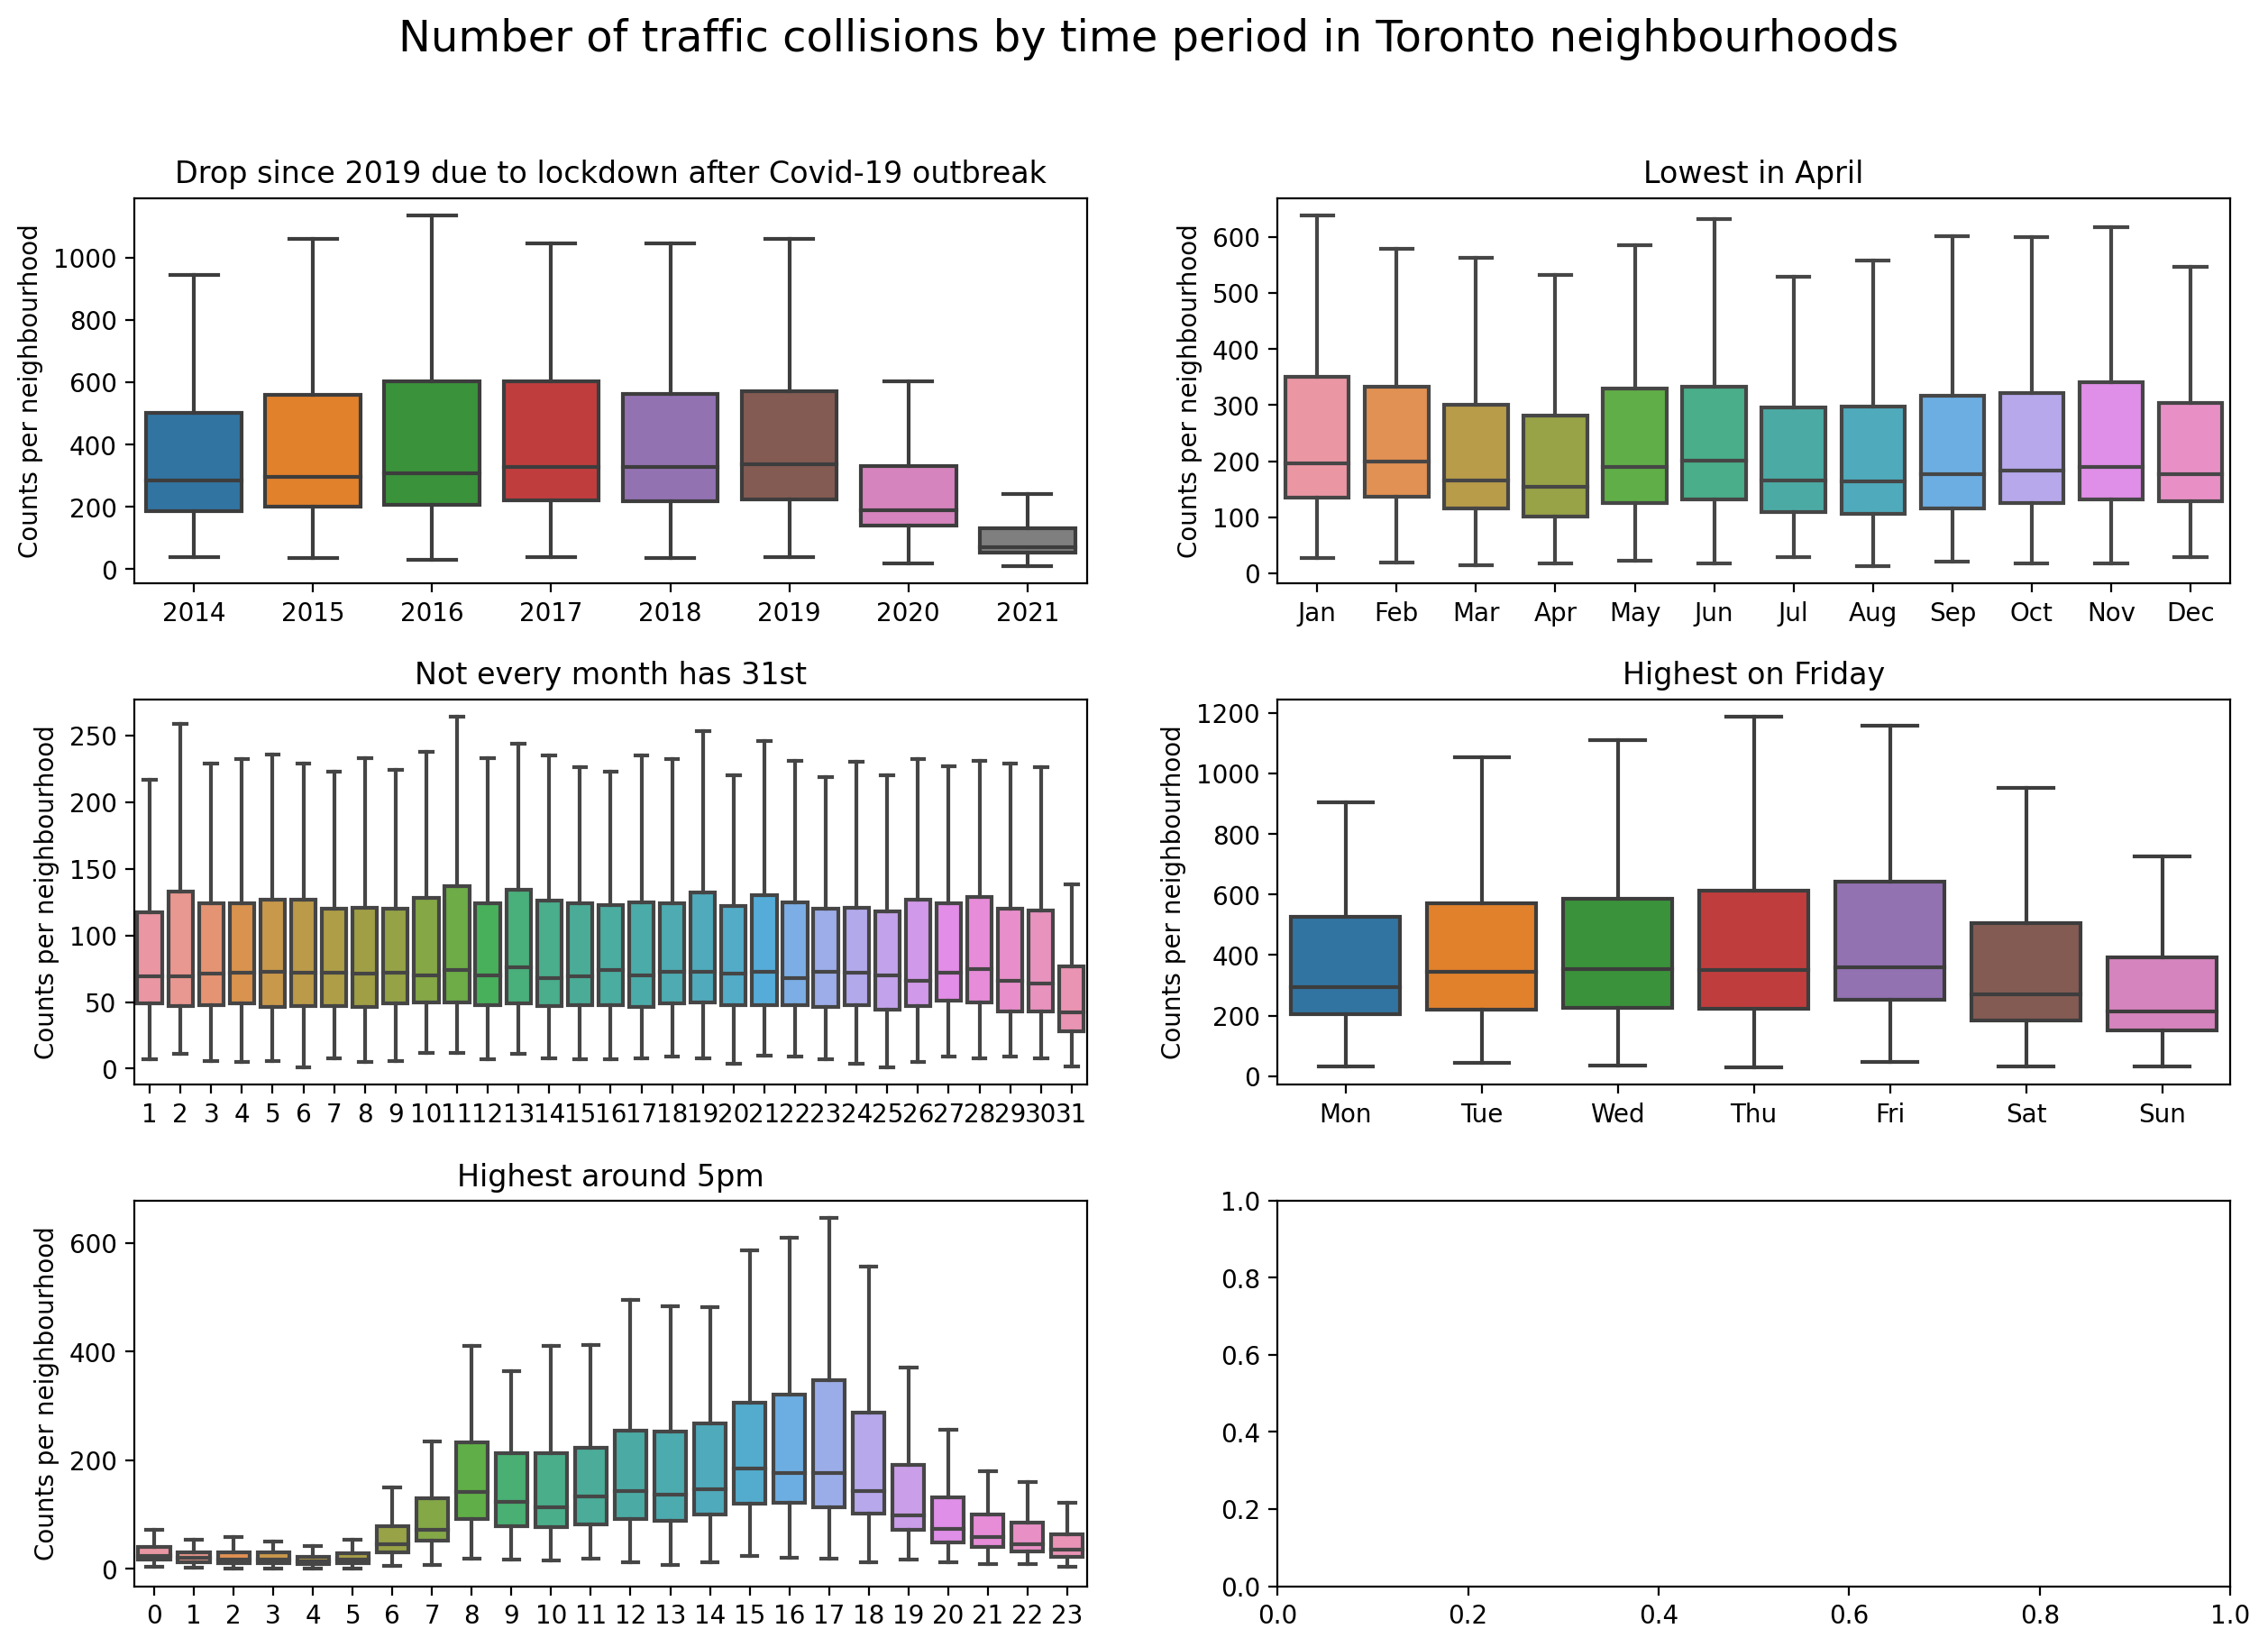

In [10]:
vars = ['occurrence_year', 
        'occurrence_month', 
        'occurrence_day',
        'occurrence_dayofweek',
        'occurrence_hour']
vars_cat = [[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
            ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            np.arange(1,32,1),
            ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            np.arange(0,24,1)
            ]
titles = ['Drop since 2019 due to lockdown after Covid-19 outbreak',
         'Lowest in April',
         'Not every month has 31st',
         'Highest on Friday',
         'Highest around 5pm']

fig, axes = plt.subplots(int(math.ceil(len(vars)/2)),2)
plt.subplots_adjust(hspace=0.3)
for var, var_cat, title, ax in zip(vars, vars_cat, titles, axes.flatten()):    
    collision_point[var] = collision_point[var].astype('category').cat.set_categories(var_cat)
    sns.boxplot(data = collision_point.groupby(['neighbourhood', var]).size().reset_index(name='count'), 
                x = var,
                y = 'count',
                showfliers = False,
                ax = ax)
    ax.set_ylabel('Counts per neighbourhood')
    ax.set_xlabel('')
    ax.set_title(title)

fig.suptitle('Number of traffic collisions by time period in Toronto neighbourhoods', size='xx-large')

# Time trend by type of collision

Text(0.5, 0.98, 'Traffic collisions in Toronto neighbourhoods')

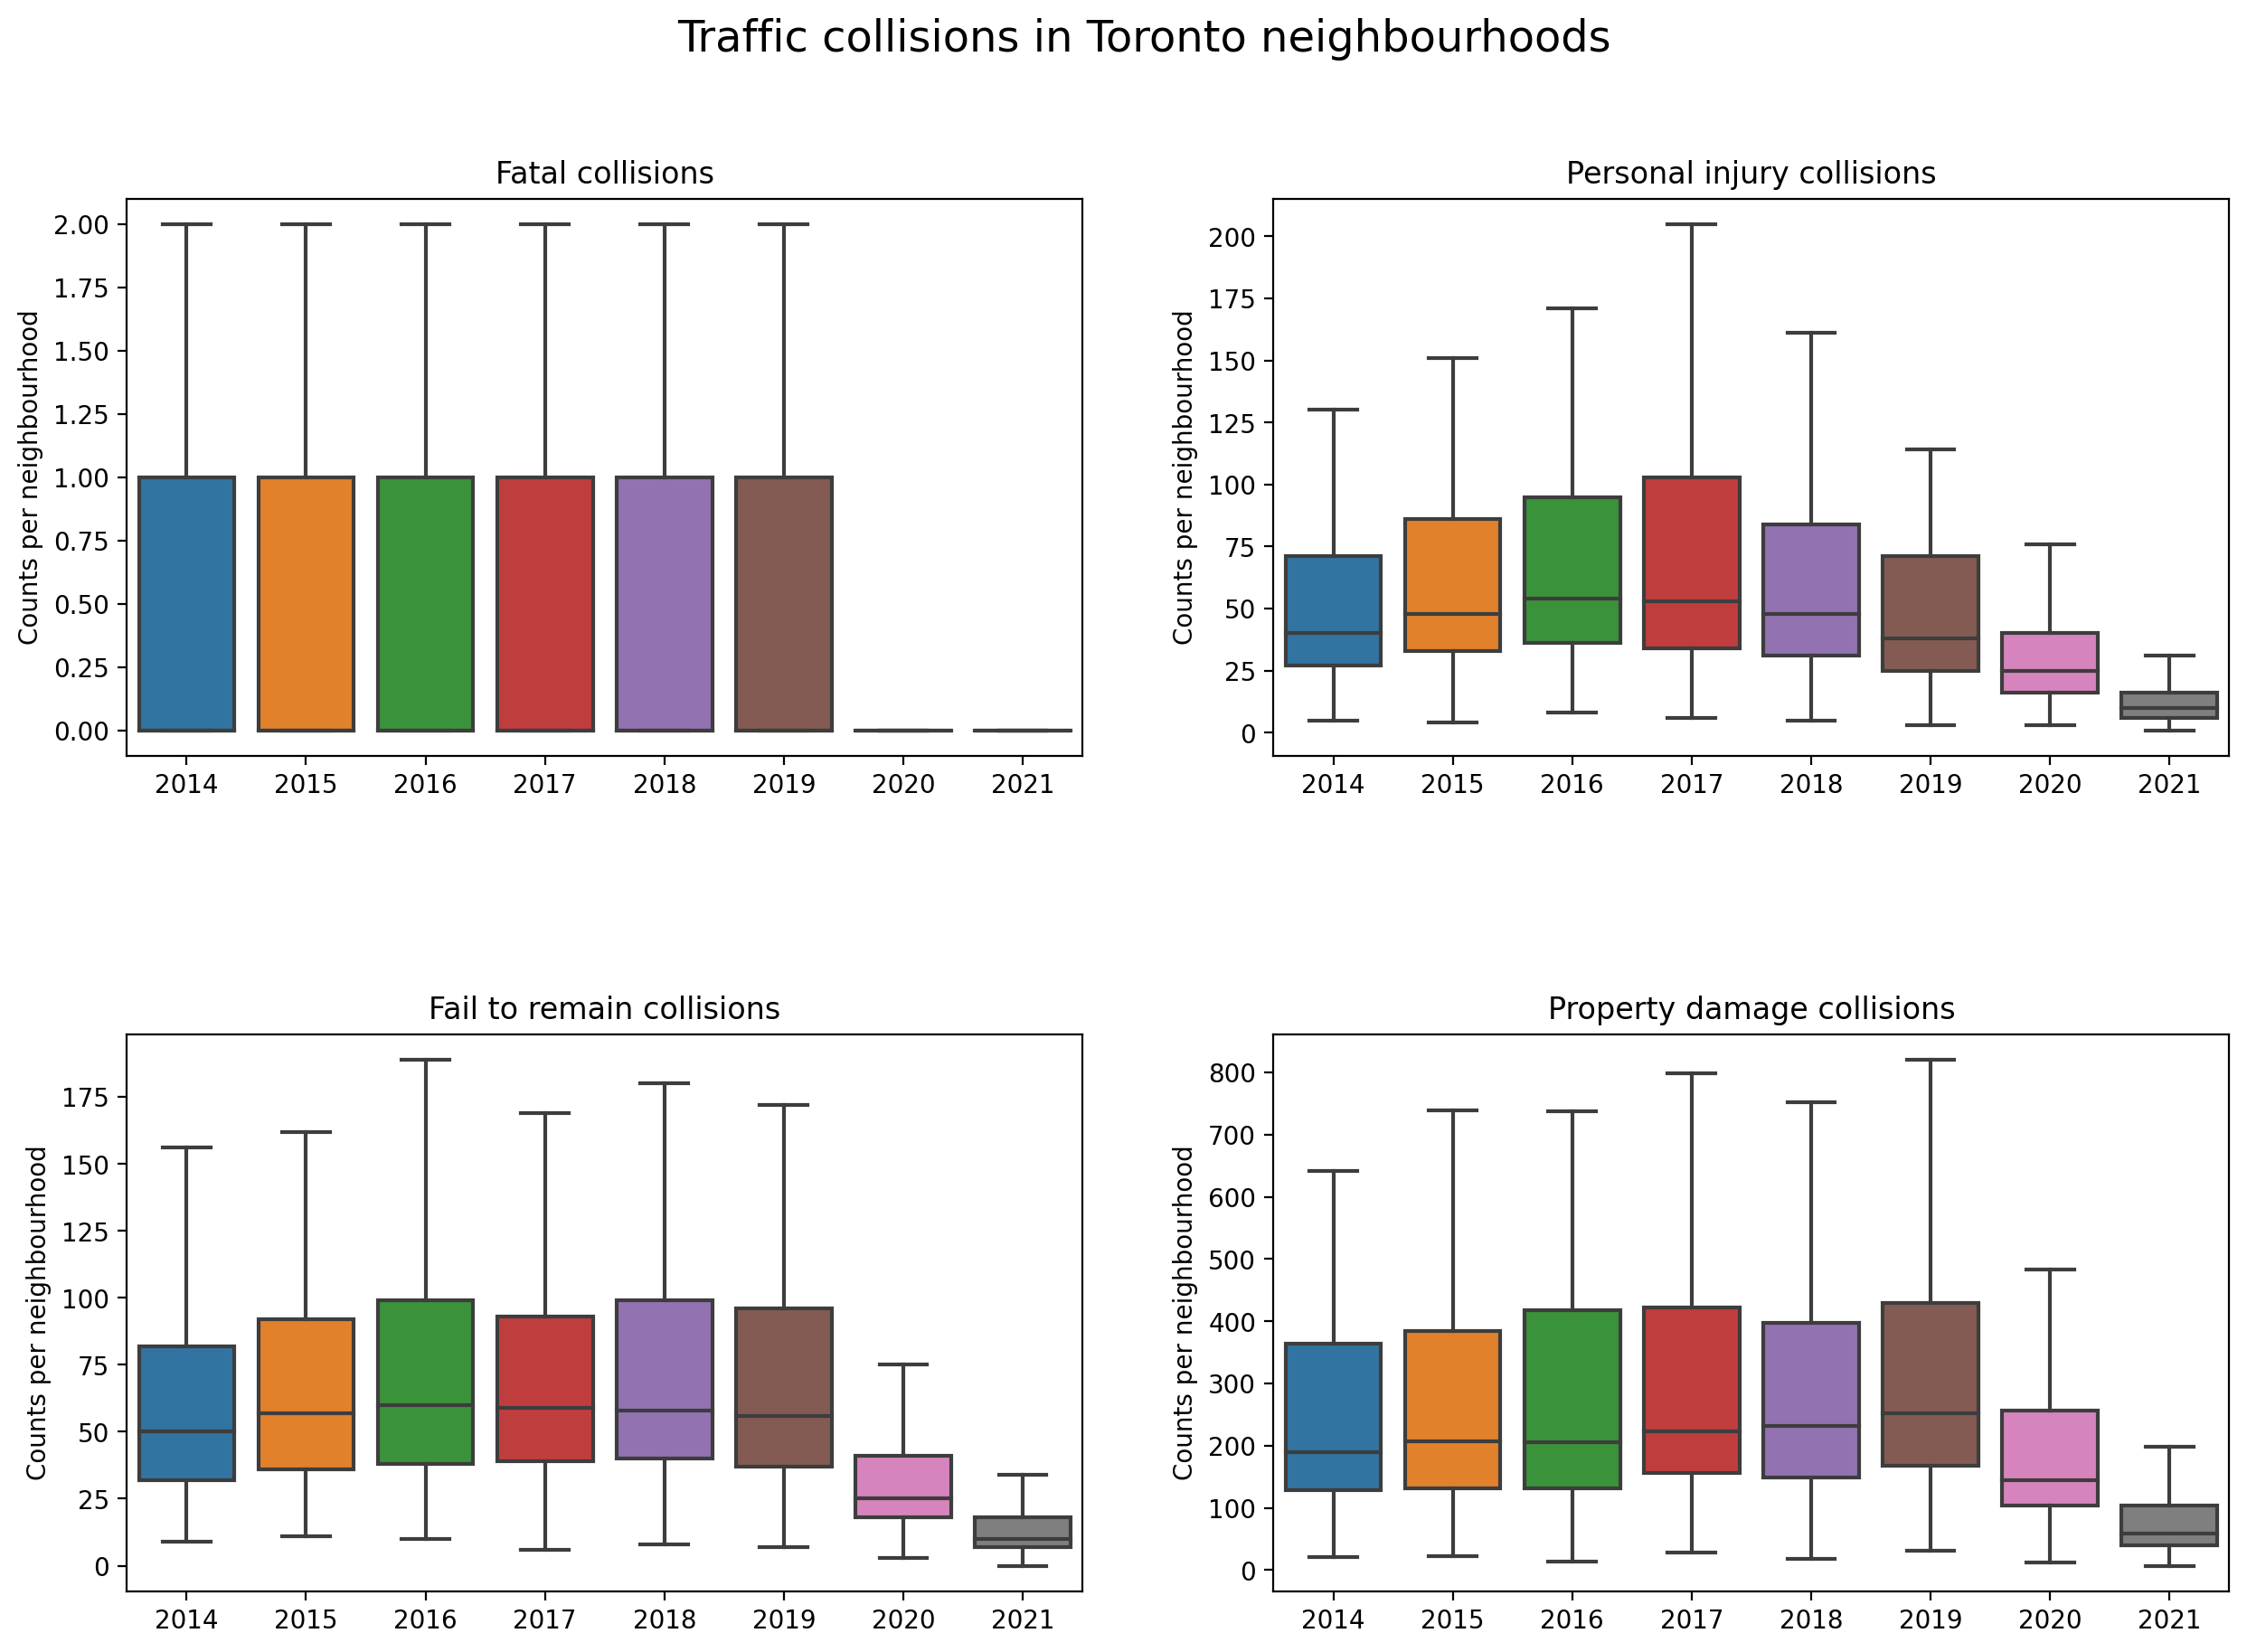

In [11]:
vars = ['fatal_collisions', 'injury_collisions', 'ftr_collisions', 'pd_collisions']
titles = ['Fatal collisions',
          'Personal injury collisions', 
          'Fail to remain collisions', 
          'Property damage collisions']
fig, axes = plt.subplots(int(math.ceil(len(vars)/2)),2)
plt.subplots_adjust(hspace=0.5)
for var, title, ax in zip(vars, titles, axes.flatten()):    
    sns.boxplot(data = collision_point.groupby(['neighbourhood', 'occurrence_year']).agg({var: 'sum'}).reset_index(), 
                x = 'occurrence_year',
                y = var,
                showfliers = False,
                ax = ax)
    ax.set_ylabel('Counts per neighbourhood')
    ax.set_xlabel('')
    ax.set_title(f"{title}")

fig.suptitle('Traffic collisions in Toronto neighbourhoods', size='xx-large')

# Neighbourhood collision rate and density

In [12]:
collision_by_quarter = pd.read_csv('../data/processed/neighbourhoods_collision.csv')
collision_by_quarter.hood_id = collision_by_quarter.hood_id.astype(str)
collision_by_quarter

neighbourhood hood_id  occurrence_year  occurrence_quarter  \
0      West Humber-Clairville       1             2014                   1   
1      West Humber-Clairville       1             2014                   2   
2      West Humber-Clairville       1             2014                   3   
3      West Humber-Clairville       1             2014                   4   
4      West Humber-Clairville       1             2014                   1   
...                       ...     ...              ...                 ...   
67195     Mount Pleasant East      99             2021                   4   
67196     Mount Pleasant East      99             2021                   1   
67197     Mount Pleasant East      99             2021                   2   
67198     Mount Pleasant East      99             2021                   3   
67199     Mount Pleasant East      99             2021                   4   

            area    population    collision_type     type       value  
0      30.145225  34745.000000         collision    count  352.000000  
1      30.145225  34745.000000         collision    count  300.000000  
2      30.145225  34745.000000         collision    count  317.000000  
3      30.145225  34745.000000         collision    count  312.000000  
4      30.145225  34745.000000  fatal_collisions    count    0.000000  
...          ...           ...               ...      ...         ...  
67195   3.088902  18133.437233    ftr_collisions  density    0.000000  
67196   3.088902  18133.437233     pd_collisions  density   15.215760  
67197   3.088902  18133.437233     pd_collisions  density   11.654625  
67198   3.088902  18133.437233     pd_collisions  density    0.000000  
67199   3.088902  18133.437233     pd_collisions  density    0.000000  

[67200 rows x 9 columns]

In [13]:
collision_by_year = collision_by_quarter.groupby(['hood_id', 'occurrence_year', 'collision_type', 'type']).value.sum().reset_index()
collision_by_year

hood_id  occurrence_year     collision_type     type        value
0           1             2014          collision    count  1281.000000
1           1             2014          collision  density    42.494292
2           1             2014          collision     rate  3686.861419
3           1             2014   fatal_collisions    count     3.000000
4           1             2014   fatal_collisions  density     0.099518
...       ...              ...                ...      ...          ...
16795      99             2021  injury_collisions  density     2.913656
16796      99             2021  injury_collisions     rate    49.632069
16797      99             2021      pd_collisions    count    83.000000
16798      99             2021      pd_collisions  density    26.870385
16799      99             2021      pd_collisions     rate   457.717966

[16800 rows x 5 columns]

In [14]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [15]:
neighbourhoods_collision = neighbourhoods[['hood_id', 'geometry']].drop_duplicates(subset = 'hood_id').merge(collision_by_year, on='hood_id', how='left')
neighbourhoods_collision

hood_id                                           geometry  \
0          97  POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
1          97  POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
2          97  POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
3          97  POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
4          97  POLYGON ((-79.39115 43.68108, -79.39137 43.680...   
...       ...                                                ...   
16795      17  POLYGON ((-79.48036 43.62107, -79.48029 43.621...   
16796      17  POLYGON ((-79.48036 43.62107, -79.48029 43.621...   
16797      17  POLYGON ((-79.48036 43.62107, -79.48029 43.621...   
16798      17  POLYGON ((-79.48036 43.62107, -79.48029 43.621...   
16799      17  POLYGON ((-79.48036 43.62107, -79.48029 43.621...   

       occurrence_year     collision_type     type        value  
0                 2014          collision    count   238.000000  
1                 2014          collision  density   204.939633  
2                 2014          collision     rate  1889.338731  
3                 2014   fatal_collisions    count     1.000000  
4                 2014   fatal_collisions  density     0.861091  
...                ...                ...      ...          ...  
16795             2021  injury_collisions  density     4.249782  
16796             2021  injury_collisions     rate    75.646095  
16797             2021      pd_collisions    count   134.000000  
16798             2021      pd_collisions  density    18.982361  
16799             2021      pd_collisions     rate   337.885892  

[16800 rows x 6 columns]

In [18]:
collision_type = neighbourhoods_collision.collision_type.unique()
collision_type

array(['collision', 'fatal_collisions', 'ftr_collisions',
       'injury_collisions', 'pd_collisions'], dtype=object)

In [19]:
# set custom order for display
custom_collision_order = ['collision','fatal_collisions', 'injury_collisions','ftr_collisions','pd_collisions']
collision_years = sorted(neighbourhoods_collision.occurrence_year.unique())

In [25]:
def plot_collision(var, title):
    fig, axes = plt.subplots(len(collision_years), len(custom_collision_order))

    for j in range(axes.shape[1]):
        # fix the range for each type of collision so we can compare across years
        vmin, vmax = neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == custom_collision_order[j]) &
                                              (neighbourhoods_collision['type'] == var)].value.agg(['min', 'max'])
        norm = TwoSlopeNorm(
            vmin=vmin, vcenter=np.mean([vmin, vmax]), vmax=vmax)
        print(custom_collision_order[j])
        for i in range(axes.shape[0]):
            try:
                neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == custom_collision_order[j]) &
                                         (neighbourhoods_collision['occurrence_year'] == collision_years[i]) &
                                         (neighbourhoods_collision['type'] == var)].\
                    plot(column='value',
                         cmap='viridis',
                         norm=norm,
                         ax=axes[i, j])
            except:
                print(
                    f"problem with {custom_collision_order[j]} and {collision_years[i]}")
                break

            axes[i, j].xaxis.set_visible(False)
            axes[i, j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(custom_collision_order[j])
            if j == 0:
                axes[i,j].set_ylabel(collision_years[i], rotation=90, size='large')

    fig.suptitle(title, size='xx-large')


## plot map

collision
fatal_collisions
injury_collisions
ftr_collisions
pd_collisions


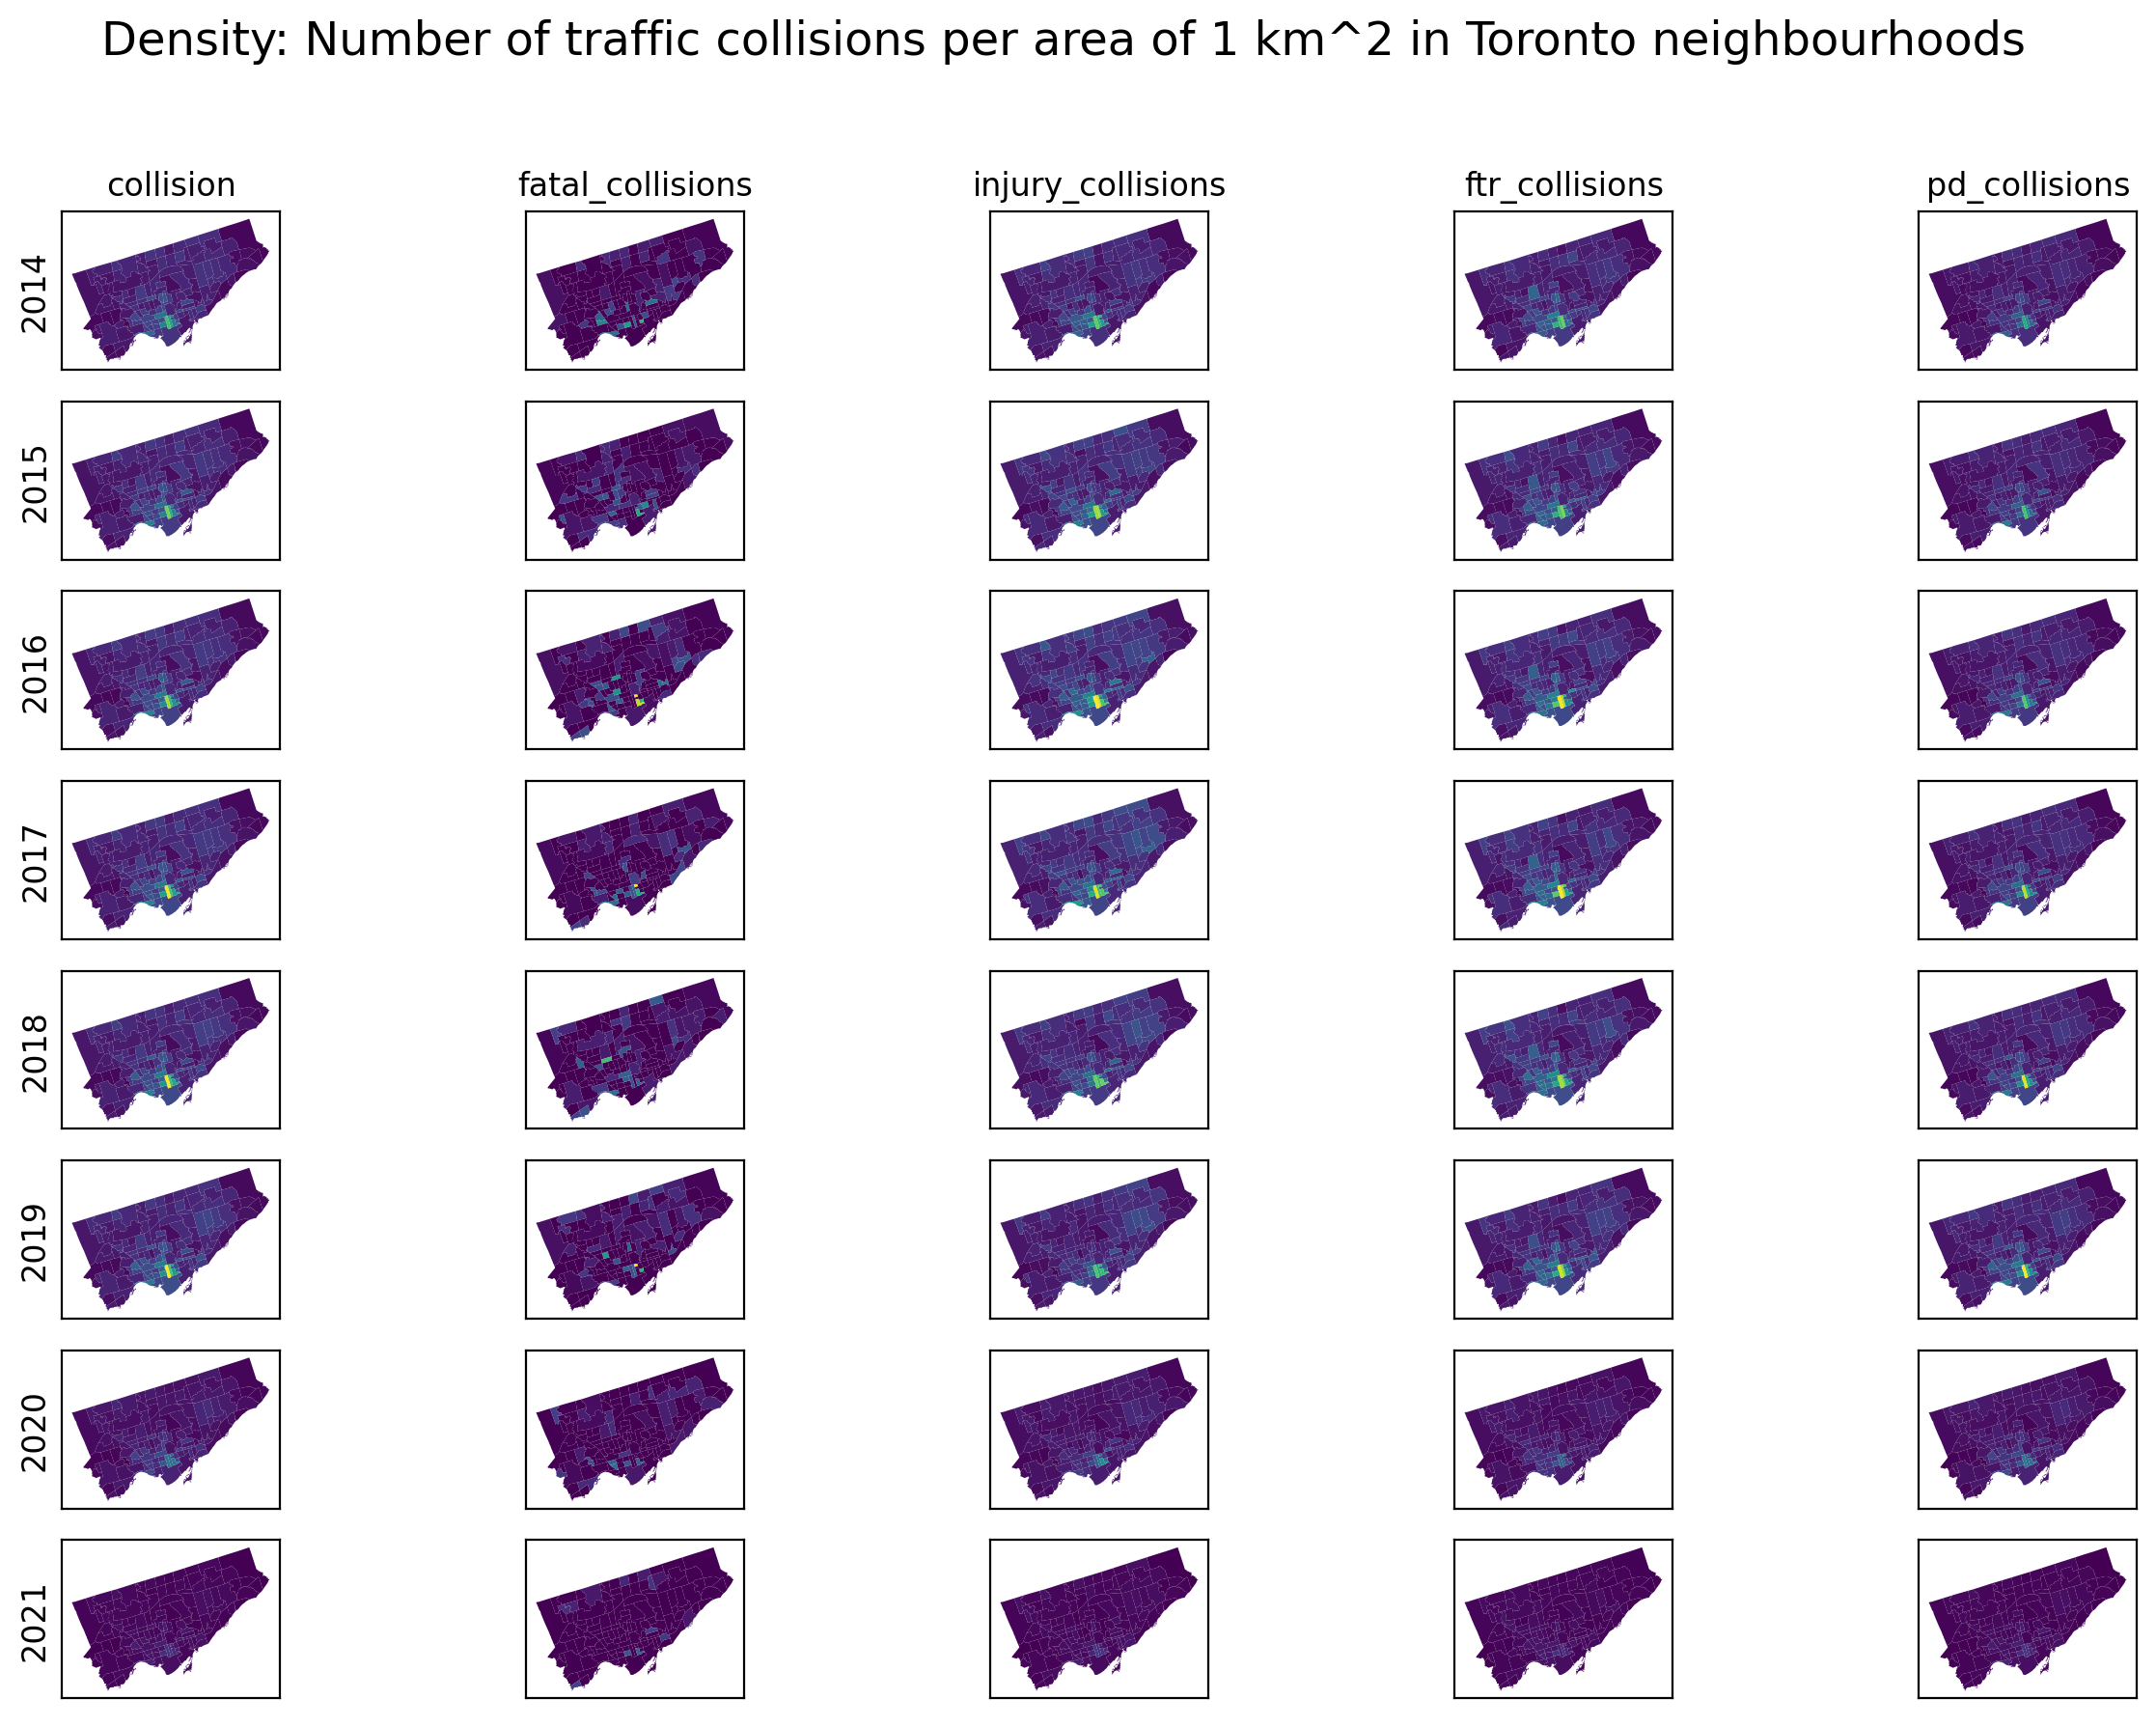

In [26]:
plot_collision('density', 'Density: Number of traffic collisions per area of 1 km^2 in Toronto neighbourhoods')

collision
fatal_collisions
injury_collisions
ftr_collisions
pd_collisions


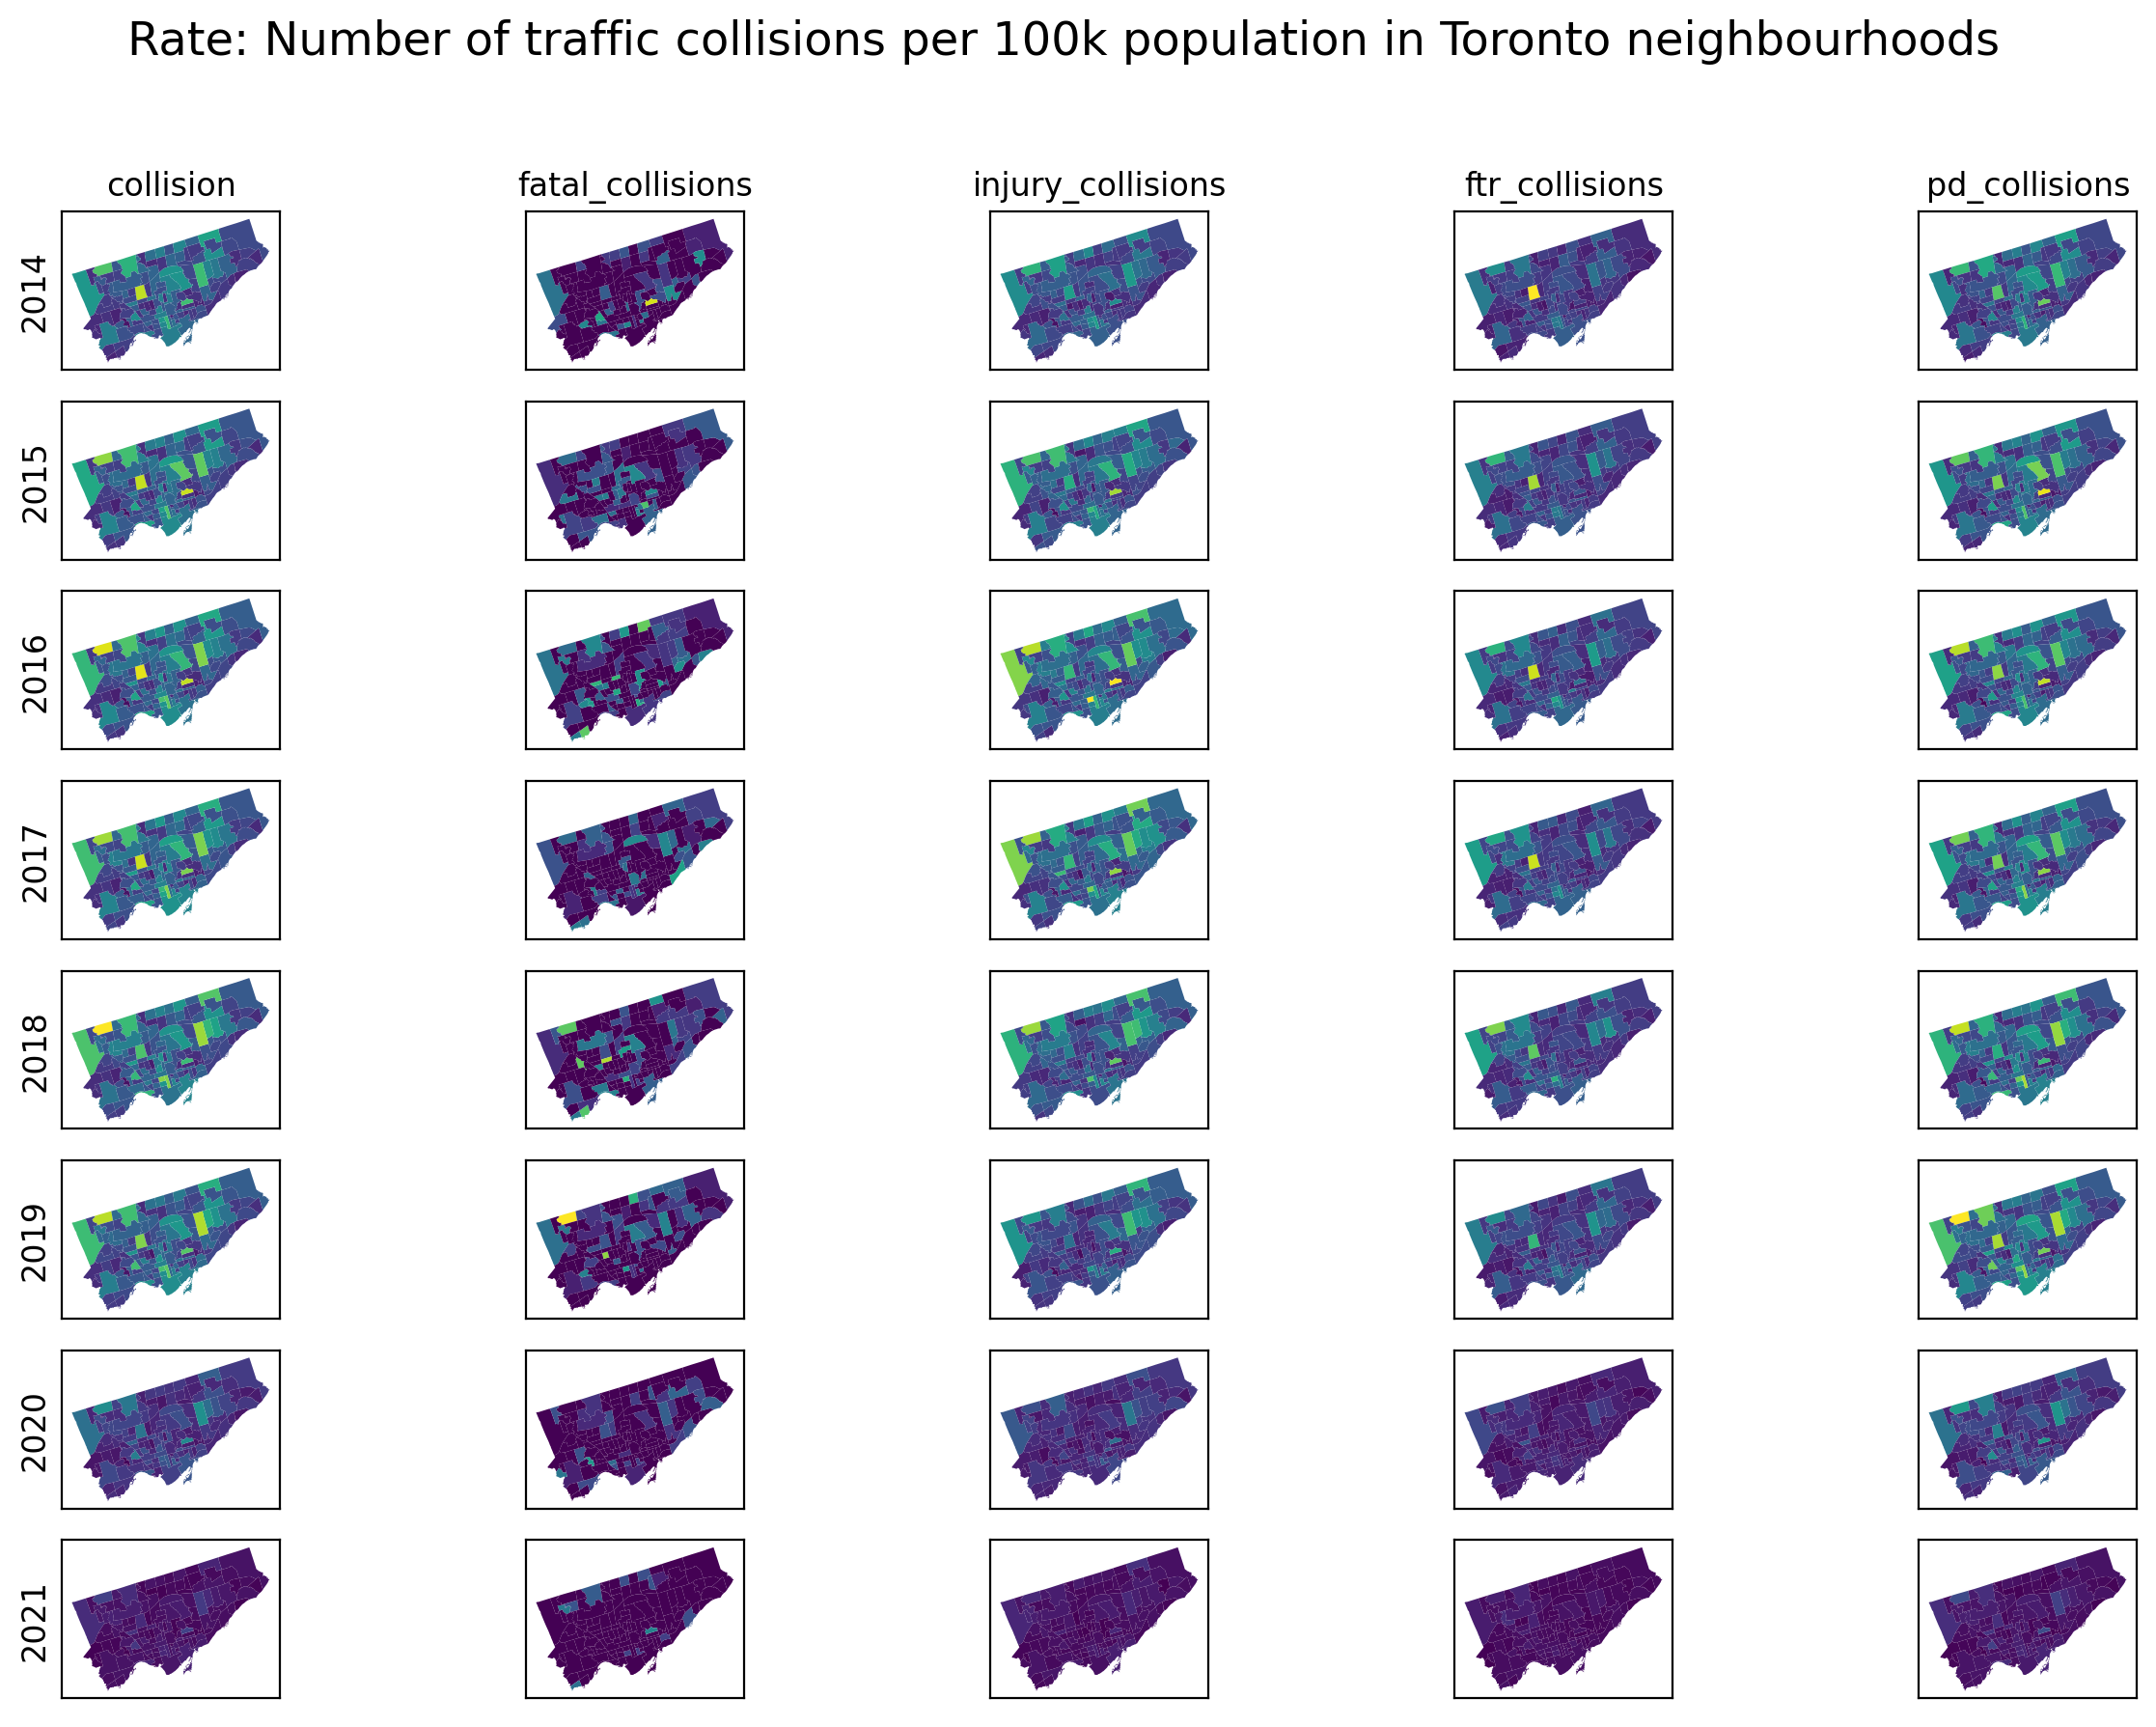

In [27]:
plot_collision('rate', 'Rate: Number of traffic collisions per 100k population in Toronto neighbourhoods')

collision
fatal_collisions
injury_collisions
ftr_collisions
pd_collisions


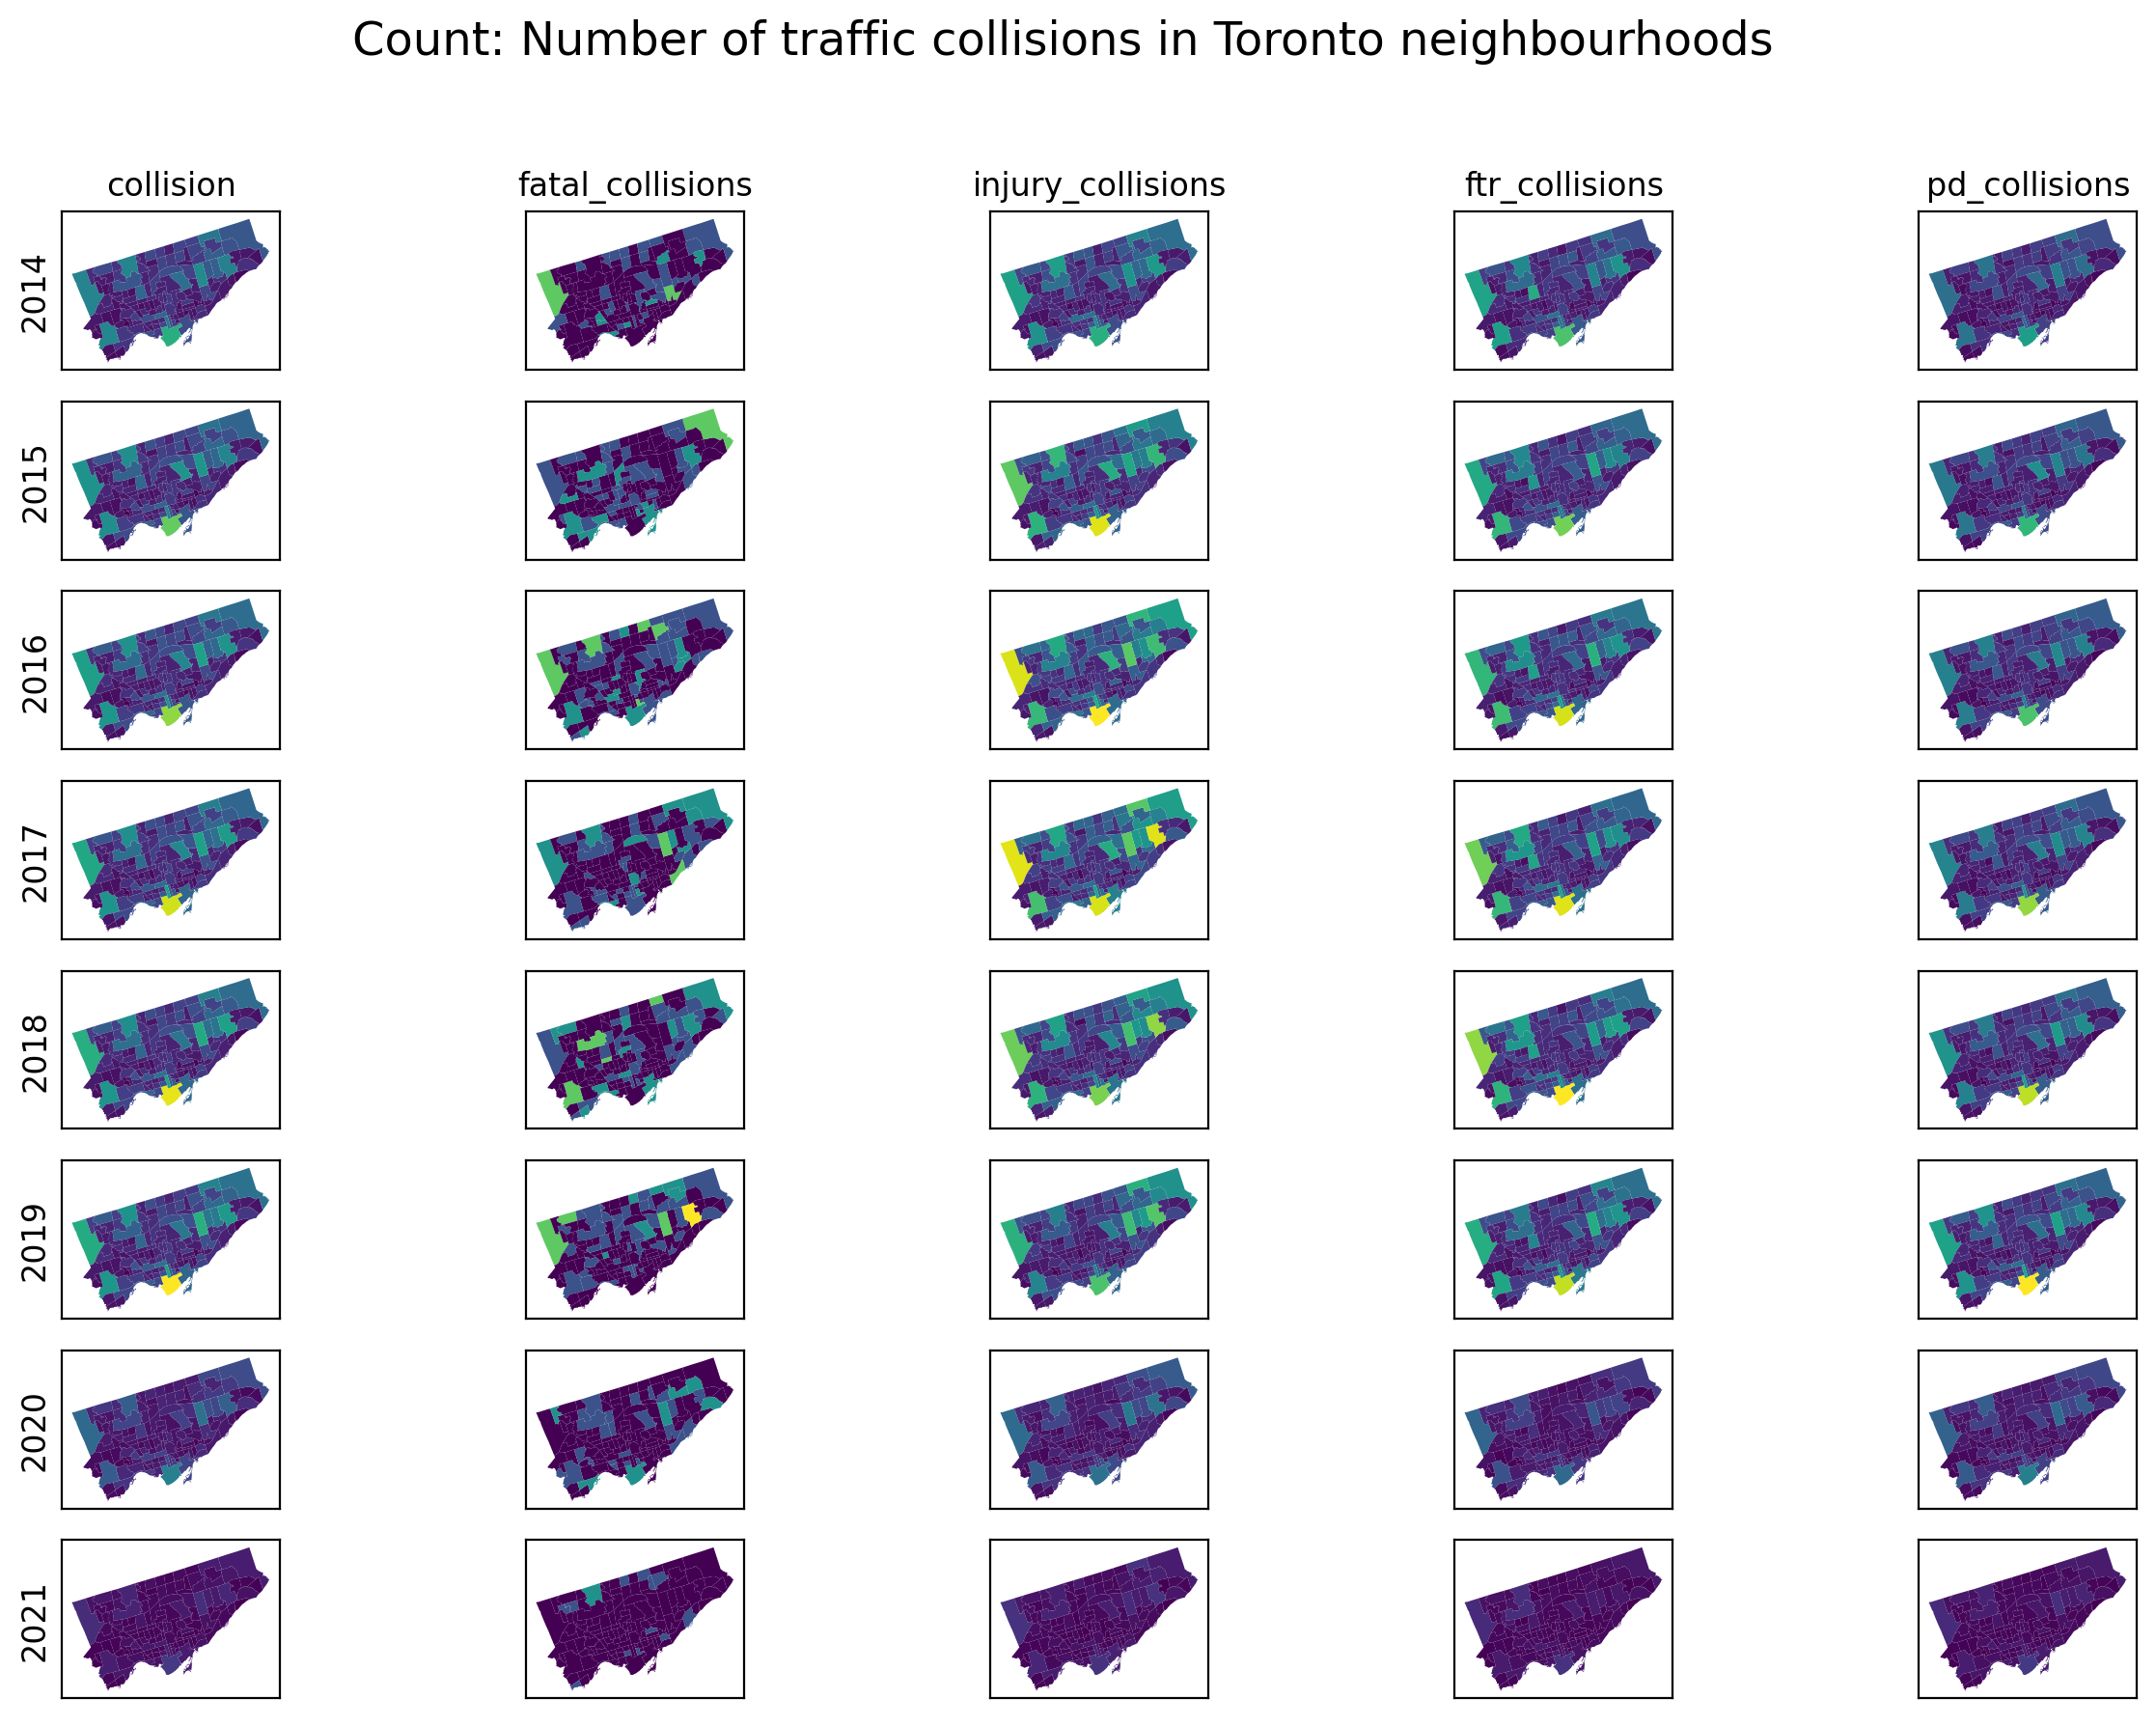

In [29]:
plot_collision('count', 'Count: Number of traffic collisions in Toronto neighbourhoods')

In [ ]:
# plotly version
# crime_allrate = pd.wide_to_long(neighbourhoods_crime[['Neighbourhood', 'hood_id', 'geometry'] + ['All_Rate' + str(year) for year in crime_years]],]], 
#                                   stubnames= "All_Rate", 
#                                   i=['Neighbourhood', 'hood_id'], 
#                                   j='year',
#                                   sep='').reset_index()

# crime_allrate.head()

# fig = px.choropleth(crime_allrate, 
#               geojson=crime_allrate.geometry,
#               locations=crime_allrate.index,
#               color = 'All_Rate',
#               animation_frame='year',
#               color_continuous_scale="Viridis",
#               hover_data=['Neighbourhood'])
# fig.update_geos(fitbounds="locations", visible=False)

Text(0.5, 257.52801096780723, 'Longitude')

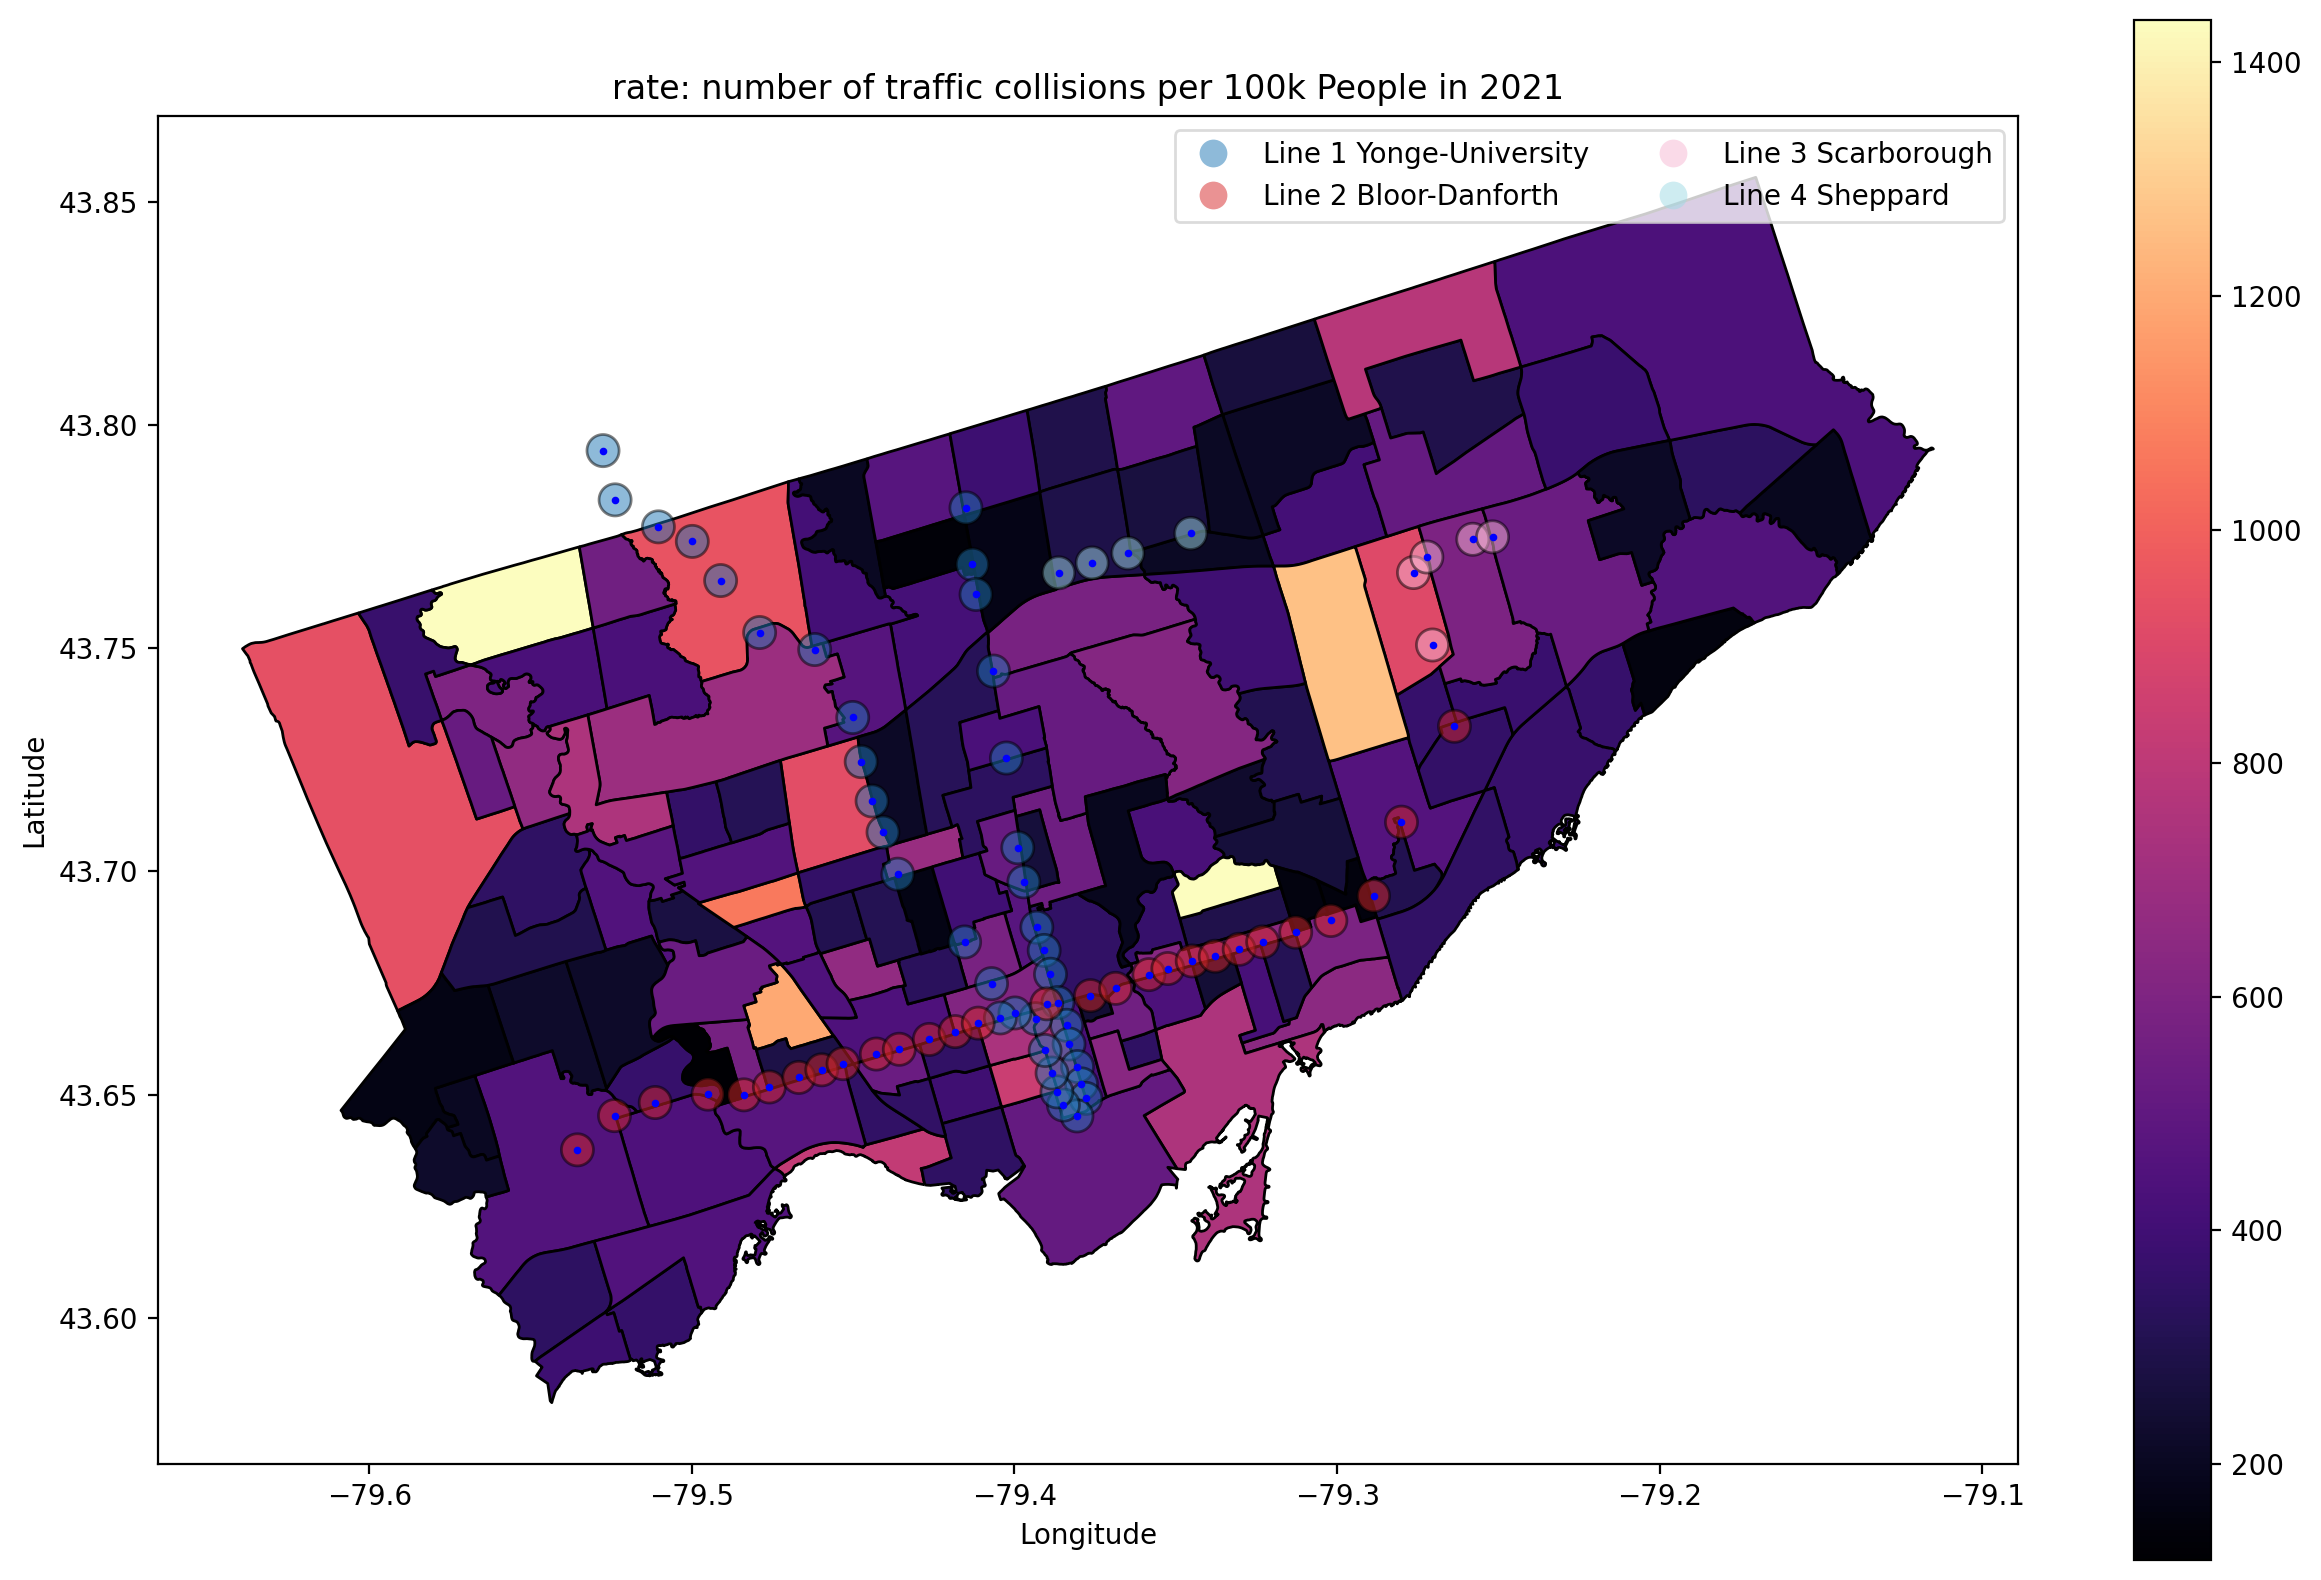

In [40]:
var = "rate"
collision_var = "collision"
year = 2021
ax = neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == collision_var) & 
                          (neighbourhoods_collision['occurrence_year'] == year) & 
                          (neighbourhoods_collision['type'] == var)].\
                              plot(column = 'value', 
                                   edgecolor = 'black',
                                   cmap = 'magma',
                                   # norm = norm,
                                   legend = True)

stations_area.plot(column = 'line', 
                edgecolor = 'black', 
                alpha = 0.5,
                cmap = 'tab20',
                legend = True,
                legend_kwds = {'loc': 'upper right', 
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                ax = ax)
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)

ax.set_title(var + ": number of traffic collisions per 100k People in " + str(year))
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

# Traffic collision around subway stations

In [41]:
collision_point['geometry'] = collision_point.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)
collision_point = gpd.GeoDataFrame(collision_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [42]:
custom_collision_order

['collision',
 'fatal_collisions',
 'injury_collisions',
 'ftr_collisions',
 'pd_collisions']

In [45]:
year = 2021
collision_around_stations = gpd.sjoin(collision_point.loc[(collision_point['occurrence_year'] == year), ['occurrence_unique_id', 'hood_id', 'geometry']], 
                                  stations_area[['station', 'geometry']],
                                  predicate='intersects')
collision_around_stations

occurrence_unique_id hood_id                    geometry  index_right  \
181           GO-2021115530      76  POINT (-79.38279 43.64976)           17   
187062       GO-20218005850      76  POINT (-79.38024 43.64865)           17   
190552       GO-20218007207      76  POINT (-79.38243 43.64529)           17   
190554       GO-20218011271      76  POINT (-79.38243 43.64529)           17   
190723       GO-20218006825      76  POINT (-79.38209 43.64961)           17   
...                     ...     ...                         ...          ...   
385436       GO-20218004389      14  POINT (-79.53270 43.63553)           38   
385438       GO-20218012672      14  POINT (-79.53270 43.63553)           38   
386905       GO-20218009181      14  POINT (-79.53488 43.64101)           38   
386906       GO-20218012058      14  POINT (-79.53488 43.64101)           38   
391620       GO-20218001588      14  POINT (-79.53798 43.63853)           38   

          station  
181     st andrew  
187062  st andrew  
190552  st andrew  
190554  st andrew  
190723  st andrew  
...           ...  
385436    kipling  
385438    kipling  
386905    kipling  
386906    kipling  
391620    kipling  

[2398 rows x 5 columns]

In [46]:
station_rank = collision_around_stations.groupby(['station']).size().sort_values(ascending=False).reset_index(name = 'collision_count')
station_rank

station  collision_count
0       bloor yonge              101
1        st patrick               91
2             queen               88
3               bay               83
4              king               74
..              ...              ...
68   downsview park                6
69        glencairn                5
70         old mill                3
71  pioneer village                2
72  york university                2

[73 rows x 2 columns]

Text(0.5, 1.0, 'Distribution of collision around stations seems in line with collision density across neighbourhoods')

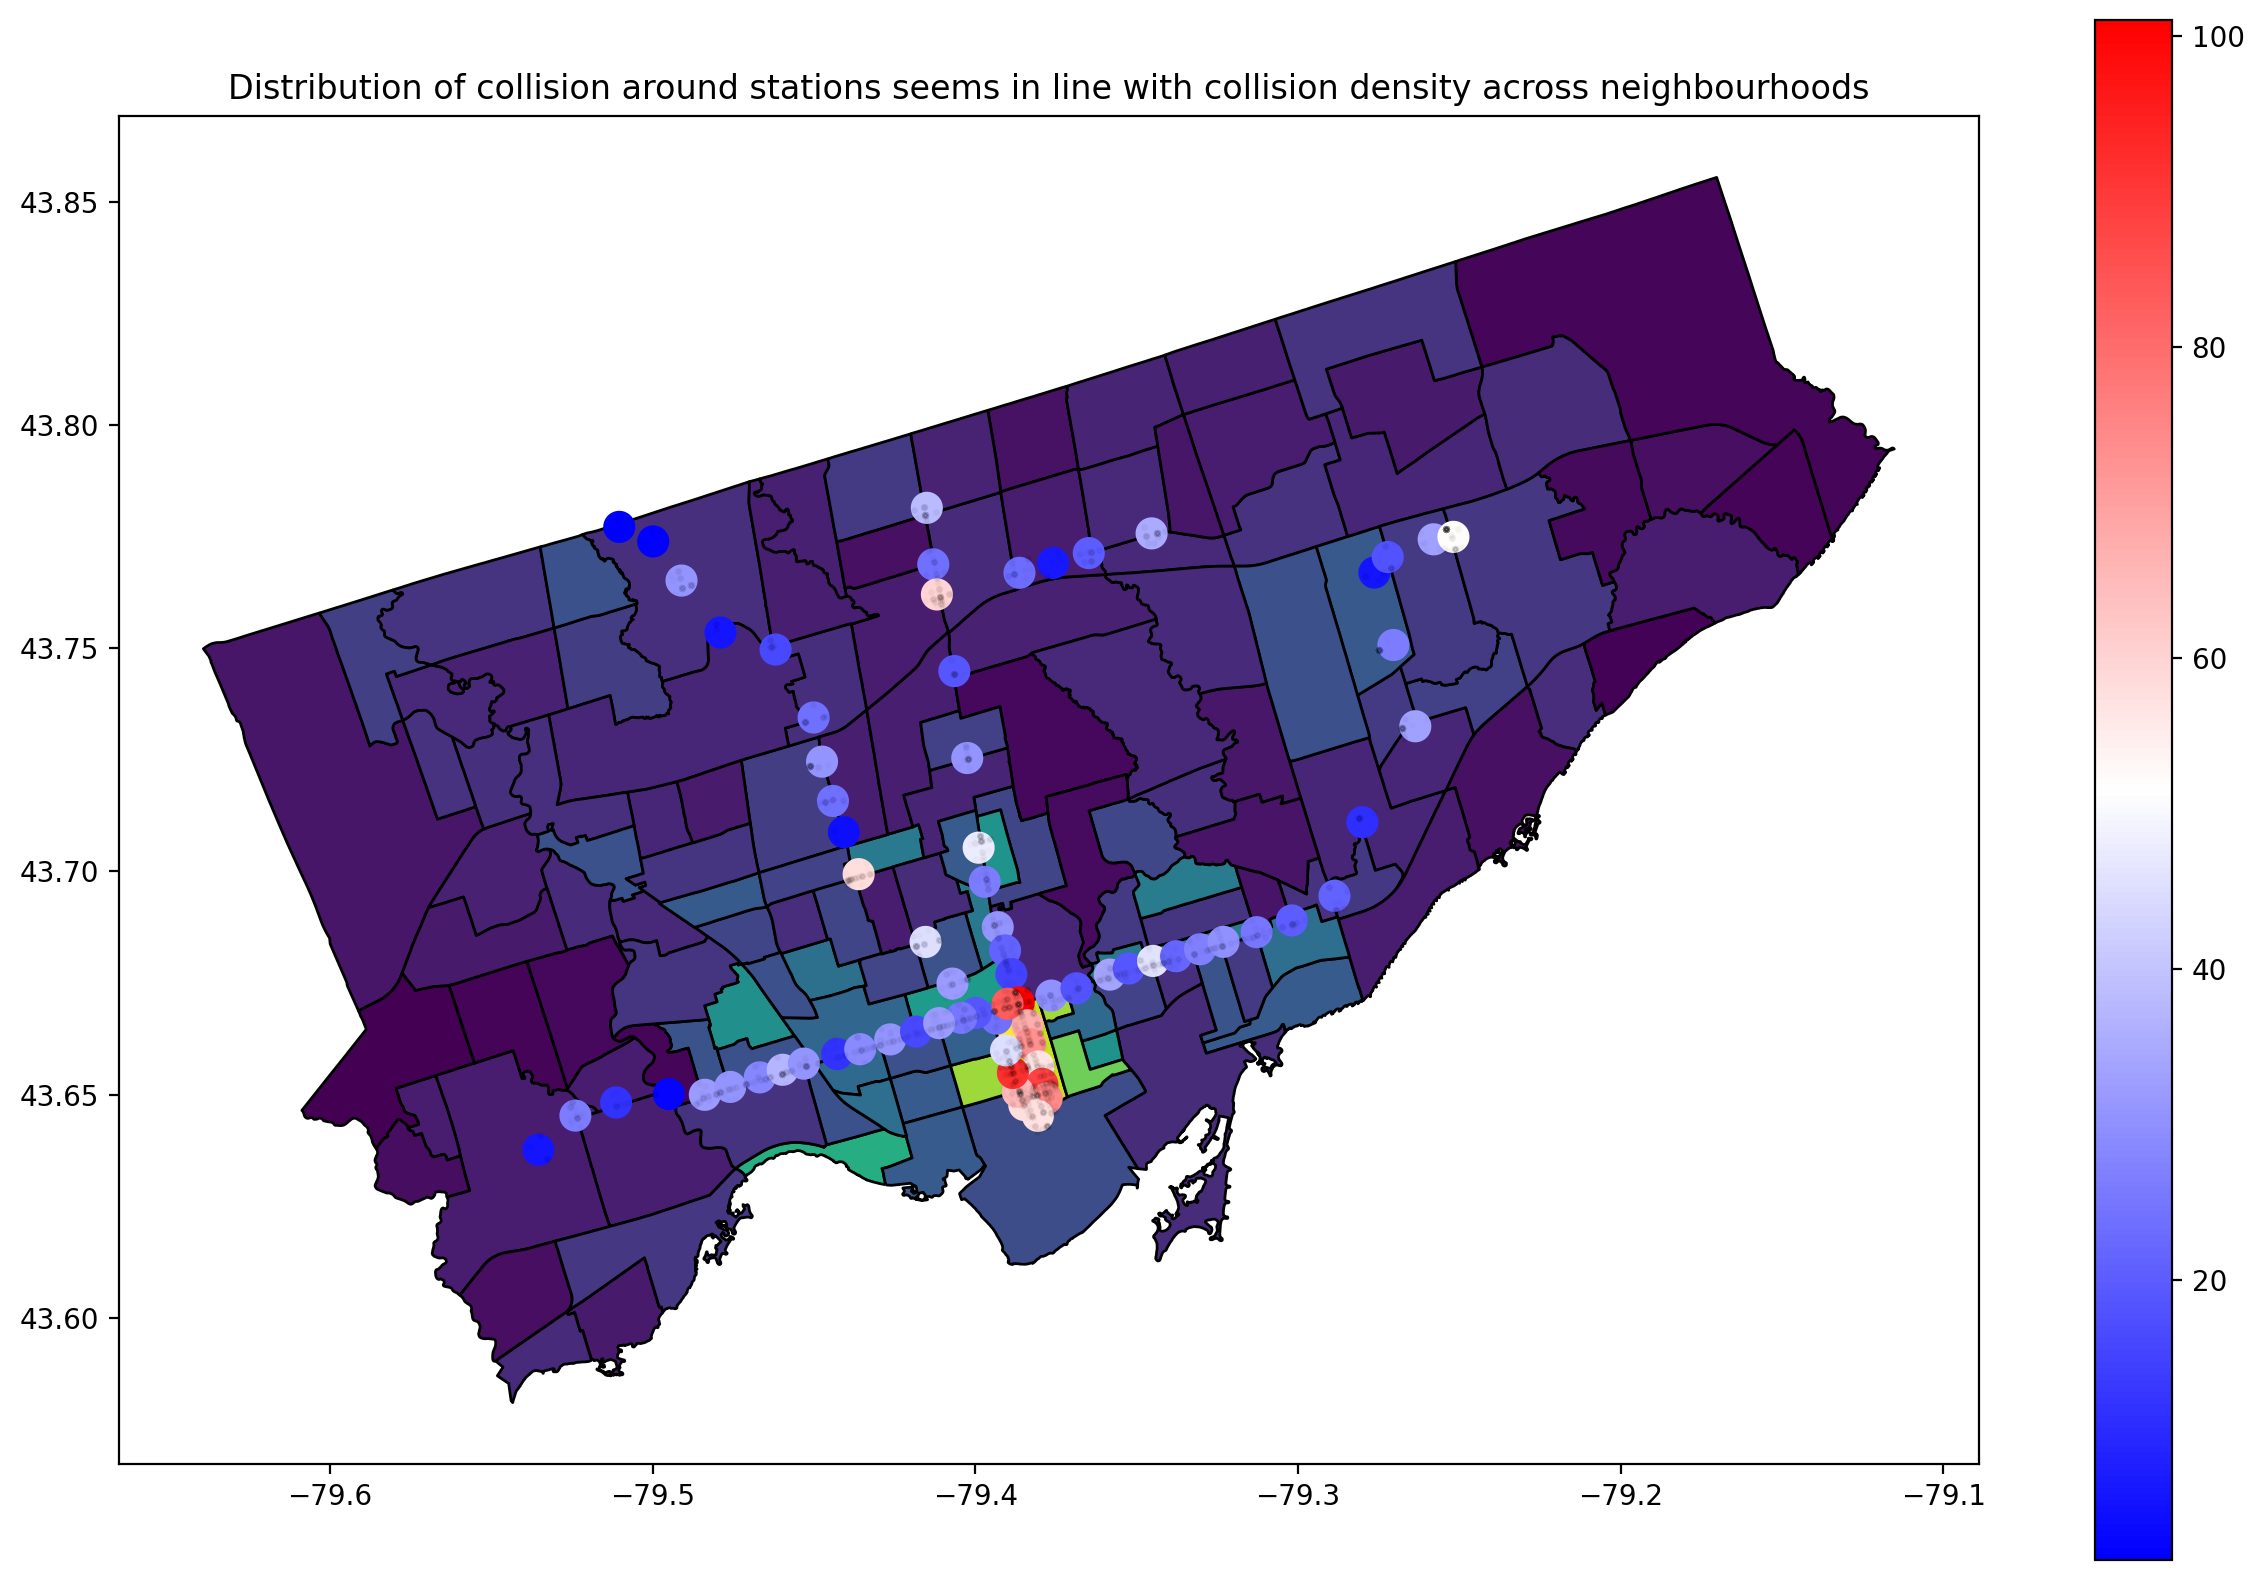

In [49]:
collision_var = "collision"
year = 2021
var = 'density'
ax = neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == collision_var) & 
                          (neighbourhoods_collision['occurrence_year'] == year) & 
                          (neighbourhoods_collision['type'] == var)].\
                              plot(column = 'value', 
                                   edgecolor = 'black',
                                   cmap = 'viridis',
                                   )
stations_area.merge(station_rank, on='station', how='left').plot(
    column = 'collision_count', 
    ax=ax, cmap = 'bwr', markersize = 3, legend = True)
collision_around_stations.plot(ax=ax, color = 'black', markersize = 3, alpha = 0.01)
ax.set_title("Distribution of collision around stations seems in line with collision density across neighbourhoods")

In [51]:
neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == 'collision') & 
                          (neighbourhoods_collision['occurrence_year'] == 2021) & 
                          (neighbourhoods_collision['type'] == 'density')].sort_values(by='value', ascending=False).head(10)

hood_id                                           geometry  \
11266      76  POLYGON ((-79.38748 43.65067, -79.38659 43.650...   
2746       75  POLYGON ((-79.37668 43.66242, -79.37654 43.662...   
8746       74  POLYGON ((-79.38053 43.67161, -79.37943 43.671...   
6226       78  POLYGON ((-79.40397 43.64719, -79.40415 43.647...   
15706      73  POLYGON ((-79.35170 43.65557, -79.35204 43.655...   
1906       85  POLYGON ((-79.42774 43.62979, -79.42944 43.630...   
6826       95  POLYGON ((-79.39410 43.66872, -79.39584 43.668...   
12226     104  POLYGON ((-79.39607 43.69566, -79.39616 43.696...   
10546      72  POLYGON ((-79.35428 43.65787, -79.35451 43.657...   
3466       90  POLYGON ((-79.48259 43.66683, -79.48268 43.667...   

       occurrence_year collision_type     type       value  
11266             2021      collision  density  139.825932  
2746              2021      collision  density  128.979083  
8746              2021      collision  density  120.226126  
6226              2021      collision  density  119.889252  
15706             2021      collision  density  109.693398  
1906              2021      collision  density   87.888812  
6826              2021      collision  density   77.767251  
12226             2021      collision  density   73.698228  
10546             2021      collision  density   72.275927  
3466              2021      collision  density   71.811238